<h1><center>EDA and Forecasting Fraud Transactions</center></h1>
<h2><center>by Hung-Yi Chang, Yu Chen, Wenzhi Liu</center></h2>
<h3>Task and Approach:</h3>
<p>
    Many transactions are being processed every day and Payability wants to build a model to predict frauds and reject them. <br>
    We are given a list of transactions from 2018 to the present in Big Query. We are going to extract the data and preprocess it. <br>
    In order to understand better the patterns of the data, we will make use of libraries like matplotlib and seaborn. <br>
    In this notebook, we will clean the data and do exploratory data analysis (EDA) to understand the data.
</p>

In [444]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

# Import data
df = pd.read_csv('data/LabeledTransactions.csv')
df = df.drop(df.columns[[0]], axis = 1)
df = df.drop('acceptor_state', axis = 1)

# Convert amount to float
def s2f(s):
    return float(s.replace(",",""))
df['cc_amount'] = df['cc_amount'].apply(s2f)

<h3>Cleaning data</h3>

In [445]:
# Add new features of time derived variables
df['user_transaction_time'] = pd.to_datetime(df['user_transaction_time'], errors='coerce', utc=True)
df['hour'] = df['user_transaction_time'].dt.hour
df['month'] = df['user_transaction_time'].dt.month
df['dayofweek'] = df['user_transaction_time'].dt.dayofweek

# Fill in NA's
df['transaction_risk_score'] = df['transaction_risk_score'].fillna(df['transaction_risk_score'].mean())
df['channel'] = df['channel'].fillna('OTHER')
df['processing_type'] = df['processing_type'].fillna('UNKNOWN')
df[['cc_amount','ledger_balance','cardholder_presence','card_presence',
    'partial_approval_capable']] = df[['cc_amount','ledger_balance','cardholder_presence','card_presence',
                                       'partial_approval_capable']].fillna(0)
df['cc_acceptor_state'] = df['cc_acceptor_state'].fillna('UNKNOWN')
df['pin_present'] = df['pin_present'].fillna(False)

# Change data types and encode cateogrical variables
cat_cols = ['channel','processing_type','cc_acceptor_state','cc_acceptor_country','cardholder_presence','card_presence',
           'partial_approval_capable','pin_present','hour','month','dayofweek']
print("Labels assigned to Categorical Variables\n")
for c in cat_cols:
    if c not in ['hour','month','dayofweek']:
        d = dict(enumerate(df[c].astype('category').cat.categories))
        print(c + ": " + str(d)+"\n")
        df[c] = df[c].astype('category').cat.codes
    df[c] = df[c].astype('category')
df['is_fraud'] = df['is_fraud'].astype('str')

# Remove user_transaction time
df = df.drop('user_transaction_time', axis = 1)

Labels assigned to Categorical Variables

channel: {0: 'ECOMMERCE', 1: 'MOTO', 2: 'OTHER'}

processing_type: {0: 'CARD_ON_FILE', 1: 'CHIP', 2: 'CHIP_FALLBACK', 3: 'MAGSTRIPE', 4: 'MANUAL', 5: 'UNKNOWN'}

cc_acceptor_state: {0: '12', 1: '17', 2: 'AB', 3: 'AL', 4: 'AR', 5: 'AZ', 6: 'BC', 7: 'CA', 8: 'CO', 9: 'CT', 10: 'DC', 11: 'DE', 12: 'FL', 13: 'GA', 14: 'HI', 15: 'IA', 16: 'ID', 17: 'IL', 18: 'IN', 19: 'KS', 20: 'KY', 21: 'LA', 22: 'MA', 23: 'MD', 24: 'ME', 25: 'MI', 26: 'MN', 27: 'MO', 28: 'MS', 29: 'NB', 30: 'NC', 31: 'ND', 32: 'NE', 33: 'NH', 34: 'NJ', 35: 'NL', 36: 'NM', 37: 'NS', 38: 'NV', 39: 'NY', 40: 'OH', 41: 'OK', 42: 'ON', 43: 'OR', 44: 'PA', 45: 'QC', 46: 'RI', 47: 'SC', 48: 'SD', 49: 'TN', 50: 'TX', 51: 'UNKNOWN', 52: 'UT', 53: 'VA', 54: 'VT', 55: 'WA', 56: 'WI', 57: 'WV', 58: 'WY'}

cc_acceptor_country: {0: 'AE', 1: 'AT', 2: 'AU', 3: 'BS', 4: 'CA', 5: 'CH', 6: 'CN', 7: 'CR', 8: 'CY', 9: 'CZ', 10: 'DE', 11: 'DK', 12: 'EE', 13: 'EG', 14: 'ES', 15: 'FR', 16: 'GB', 17: 'HK'

In [446]:
# Quick glimpse on the data
df.head()

,channel,transaction_risk_score,processing_type,cc_amount,ledger_balance,cc_acceptor_state,cc_acceptor_country,cardholder_presence,card_presence,partial_approval_capable,pin_present,date,is_fraud,hour,month,dayofweek
0,2,24.0,1,192.19,187.20,39,30,1,1,1,0,2018-12-25,0,1,12,1
1,0,18.0,4,7.19,0.00,7,30,0,0,0,0,2018-12-25,0,22,12,1
2,0,33.0,4,17.50,1404.67,7,30,0,0,0,0,2018-12-25,0,22,12,1
3,2,32.0,1,10.00,14.66,7,30,1,1,1,0,2018-12-25,0,5,12,1
4,2,26.0,3,31.33,49.95,50,30,1,1,1,0,2018-12-25,0,21,12,1


In [447]:
# The data has 24443 rows and 16 columns
df.shape

(24443, 16)

In [448]:
# The data has 16 different variables (columns)
df.columns

Index(['channel', 'transaction_risk_score', 'processing_type', 'cc_amount',
       'ledger_balance', 'cc_acceptor_state', 'cc_acceptor_country',
       'cardholder_presence', 'card_presence', 'partial_approval_capable',
       'pin_present', 'date', 'is_fraud', 'hour', 'month', 'dayofweek'],
      dtype='object')

In [449]:
# Types for each variable
df.dtypes

channel                     category
transaction_risk_score       float64
processing_type             category
cc_amount                    float64
ledger_balance               float64
cc_acceptor_state           category
cc_acceptor_country         category
cardholder_presence         category
card_presence               category
partial_approval_capable    category
pin_present                 category
date                          object
is_fraud                      object
hour                        category
month                       category
dayofweek                   category
dtype: object

In [450]:
# Number of unique values for each variable
df.nunique(axis=0)

channel                         3
transaction_risk_score         98
processing_type                 6
cc_amount                    8638
ledger_balance              22464
cc_acceptor_state              59
cc_acceptor_country            33
cardholder_presence             2
card_presence                   2
partial_approval_capable        2
pin_present                     1
date                          269
is_fraud                        2
hour                           24
month                          12
dayofweek                       7
dtype: int64

In [451]:
# Summarizes numeric variables
df.describe().applymap(lambda x: f"{x:0.3f}")

,transaction_risk_score,cc_amount,ledger_balance
count,24443.000,24443.000,24443.000
mean,12.897,83.602,10027.907
std,12.449,295.226,17352.258
min,1.000,0.010,-181.010
25%,3.000,14.200,532.080
50%,10.000,26.480,3270.340
75%,19.000,52.790,11134.050
max,99.000,10000.000,173250.170


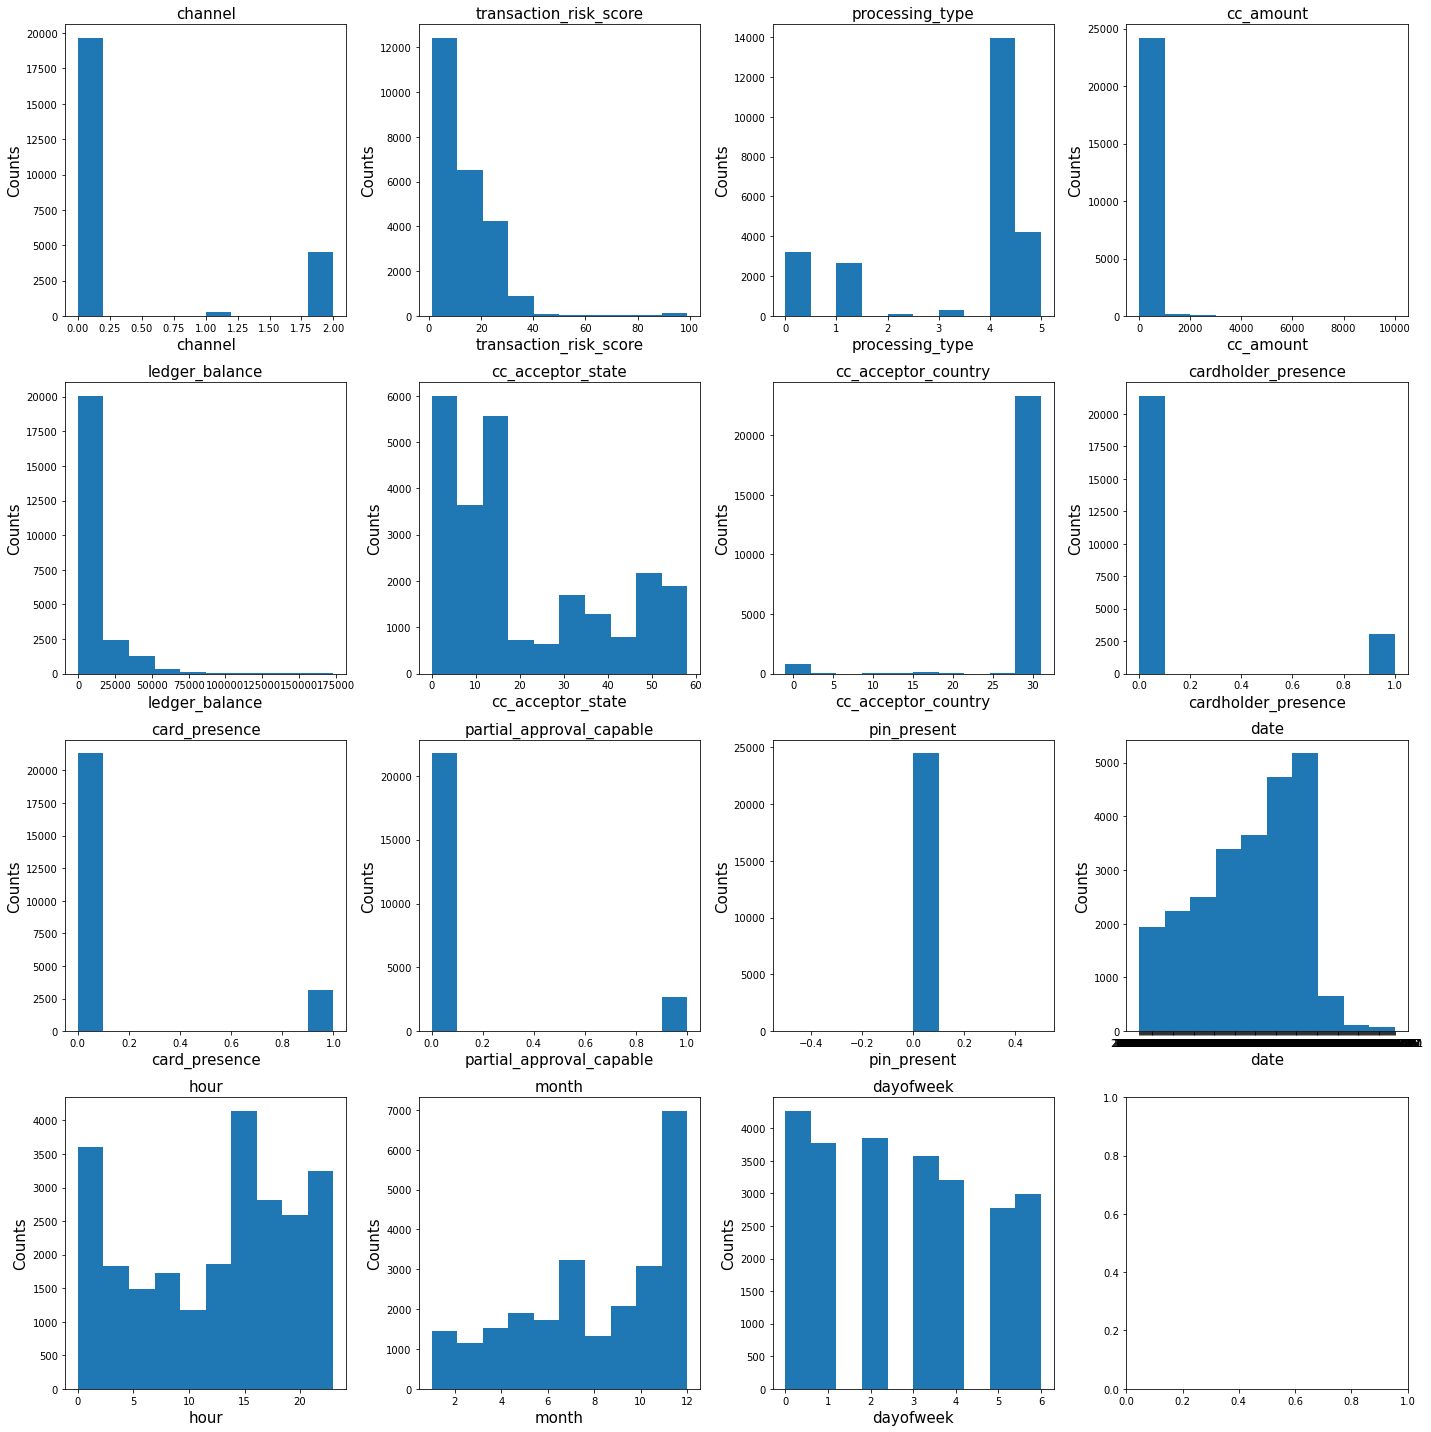

In [452]:
# Univariate distributions of all variables
var = [['channel', 'transaction_risk_score', 'processing_type', 'cc_amount'],
       ['ledger_balance', 'cc_acceptor_state', 'cc_acceptor_country','cardholder_presence'],
       ['card_presence', 'partial_approval_capable','pin_present', 'date'], 
       ['hour', 'month', 'dayofweek']]

fig, axs = plt.subplots(4, 4, figsize=(20,20))
for r in range(4):
    for c in range(4):
        if r == 3:
            if c == 3:
                break
        axs[r, c].hist(df[var[r][c]])
        axs[r, c].set_title(var[r][c], fontsize = 15)
        axs[r, c].set_xlabel(var[r][c], fontsize = 15)
        axs[r, c].set_ylabel('Counts', fontsize = 15)
        
fig.tight_layout()